In [14]:
import numpy as np
import pandas as pd
import torch

from typing import Callable

In [8]:
def DFT_1d(arr: np.ndarray, inverse: bool = False) -> np.ndarray:
    """
    Returns the DFT of the array `arr`, using the equation above.
    """
    N = arr.shape[0]
    powers = np.outer(np.arange(N), np.arange(N))
    left = np.exp(-2j * np.pi / N) ** powers
    if inverse:
        left = np.linalg.inv(left)

    return left @ arr


def integrate_function(func: Callable, x0: float, x1: float, n_samples: int = 1000):
    """
    Calculates the approximation of the Riemann integral of the function `func`, 
    between the limits x0 and x1.

    You should use the Left Rectangular Approximation Method (LRAM).
    """
    x = np.linspace(x0, x1, n_samples)
    dx = x[1] - x[0]
    y = func(x)
    return (y * dx).sum()


def integrate_product(func1: Callable, func2: Callable, x0: float, x1: float, n_samples: int = 1000):
    """
    Computes the integral of the function x -> func1(x) * func2(x).
    """
    x = np.linspace(x0, x1, n_samples)
    dx = x[1] - x[0]
    y = func1(x) * func2(x)
    return (y * dx).sum()


def calculate_fourier_series(func: Callable, max_freq: int = 50):
    """
    Calculates the fourier coefficients of a function, 
    assumed periodic between [-pi, pi].

    Your function should return ((a_0, A_n, B_n), func_approx), where:
        a_0 is a float
        A_n, B_n are lists of floats, with n going up to `max_freq`
        func_approx is the fourier approximation, as described above
    """

    a_0 = integrate_function(func, -np.pi, np.pi) / np.pi

    N = np.arange(1, max_freq + 1)
    A_n = []
    for n in N:
        a = integrate_product(func, lambda x: np.cos(n*x), -np.pi, np.pi) / np.pi
        A_n.append(a)

    B_n = []
    for n in np.arange(1, max_freq + 1):
        b = integrate_product(func, lambda x: np.sin(n*x), -np.pi, np.pi) / np.pi
        B_n.append(b)

    func_approx = lambda x: a_0 / 2 + \
        (np.array(A_n) * np.cos(N * x)).sum() + \
        (np.array(B_n) * np.sin(N * x)).sum()
    func_approx = np.vectorize(func_approx)

    return ((a_0, A_n, B_n), func_approx)

In [56]:
def train_nn(target_func, num_freqs=2, total_steps=4000, lr=1e-6, loss_type='L2'):
    x = torch.linspace(-torch.pi, torch.pi, 2000)
    y = target_func(x)

    x_cos = torch.stack([torch.cos(n*x) for n in range(1, num_freqs+1)])
    x_sin = torch.stack([torch.sin(n*x) for n in range(1, num_freqs+1)])

    a_0 = torch.randn(1, requires_grad=True)
    A_n = torch.randn(num_freqs, requires_grad=True)
    B_n = torch.randn(num_freqs, requires_grad=True)

    y_pred_list = []
    loss_list = []
    coeffs_list = []

    for step in range(total_steps):

        # compute `y_pred` using your coeffs, and the terms `x_cos`, `x_sin`
        y_pred = (0.5 * a_0) + (A_n @ x_cos) + (B_n @ x_sin)

        # compute `loss`, which is the sum of squared error between `y` and `y_pred`
        if loss_type == 'L2':
            sq_error = (y - y_pred) ** 2
            loss = sq_error.sum()
        else:
            abs_error = abs(y - y_pred)
            loss = abs_error.sum()      

        if step % 100 == 0:
            # print(f"loss = {loss:.3f}")
            loss_list.append(loss.item())
            coeffs_list.append([a_0.item(), A_n.clone().detach().numpy(), B_n.clone().detach().numpy()])
            y_pred_list.append(y_pred.detach().numpy())

        # compute gradients of coeffs with respect to `loss`
        loss.backward()

        # update weights using gradient descent (using the parameter `lr`)
        with torch.no_grad():
            a_0 -= a_0.grad * lr
            A_n -= A_n.grad * lr
            B_n -= B_n.grad * lr
            a_0.grad = None
            A_n.grad = None
            B_n.grad = None

    return (coeffs_list, loss_list, y_pred_list)

### Compare your results from parts 1 and 2

<AxesSubplot:xlabel='x'>

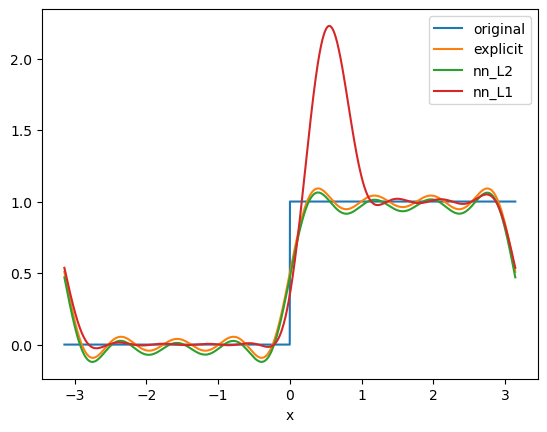

In [59]:
func = lambda x: 1 * (x > 0)

coeffs_list, loss_list, y_pred_list = train_nn(func, num_freqs=8)
coeffs_list_L1, loss_list_L1, y_pred_list_L1 = train_nn(func, num_freqs=8, loss_type='L1')
explicit_coeffs, explicit_fnc = calculate_fourier_series(func, max_freq=8)

df = pd.DataFrame()
df['x'] = np.linspace(-np.pi, np.pi, 2000)
df['original'] = func(df['x'])
df['explicit'] = explicit_fnc(df['x'])
df['nn_L2'] = y_pred_list[-1]
df['nn_L1'] = y_pred_list_L1[-1]

df.plot(x='x')

In [25]:
nn_coeffs = coeffs_list[-1]

In [44]:
nn = nn_coeffs[0]
exp = explicit_coeffs[0]
pct_diff = 100 * (exp - nn) / exp
print(f'nn = {nn:.6f}, exp = {exp:.6f}')

nn = 0.990348, exp = 1.001001


In [45]:
for nn, exp in zip(nn_coeffs[1], explicit_coeffs[1]):
    pct_diff = 100 * (exp - nn) / exp
    print(f'nn = {nn:.6f}, exp = {exp:.6f}')

nn = 0.000747, exp = -0.001001
nn = 0.000023, exp = 0.001001
nn = -0.000463, exp = -0.001001
nn = -0.000024, exp = 0.001001
nn = -0.000130, exp = -0.001001
nn = -0.000677, exp = 0.001001
nn = 0.000194, exp = -0.001001
nn = 0.000246, exp = 0.001001


In [46]:
for nn, exp in zip(nn_coeffs[2], explicit_coeffs[2]):
    pct_diff = 100 * (exp - nn) / exp
    print(f'nn = {nn:.6f}, exp = {exp:.6f}')

nn = 0.636214, exp = 0.636619
nn = 0.000459, exp = 0.000003
nn = 0.211465, exp = 0.212205
nn = 0.000324, exp = 0.000006
nn = 0.127478, exp = 0.127321
nn = 0.000456, exp = 0.000009
nn = 0.090898, exp = 0.090942
nn = -0.000330, exp = 0.000013


### Fourier series convergence

<AxesSubplot:xlabel='num_freqs'>

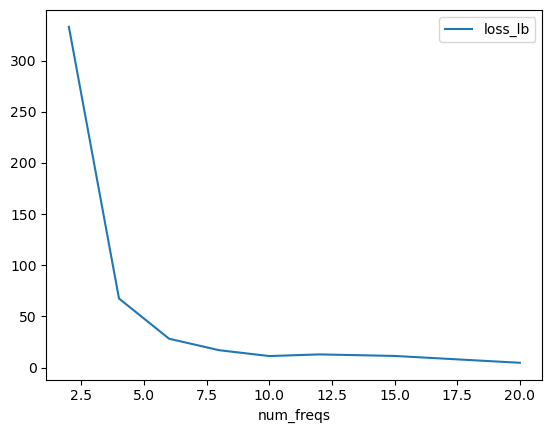

In [65]:
func = lambda x: x ** 2
final_loss = []
freqs_list = [2, 4, 6, 8, 10, 12, 15, 20]

for freq in freqs_list:
    coeffs_list, loss_list, y_pred_list = train_nn(func, num_freqs=freq)
    final_loss.append(loss_list[-1])

df = pd.DataFrame()
df['num_freqs'] = freqs_list
df['loss_lb'] = final_loss
df.plot(x='num_freqs')

<AxesSubplot:xlabel='num_freqs'>

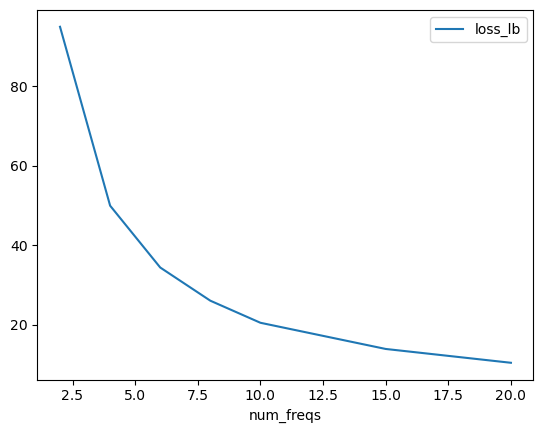

In [68]:
func = lambda x: np.heaviside(x, 0.5)
final_loss = []
freqs_list = [2, 4, 6, 8, 10, 12, 15, 20]

for freq in freqs_list:
    coeffs_list, loss_list, y_pred_list = train_nn(func, num_freqs=freq)
    final_loss.append(loss_list[-1])

df = pd.DataFrame()
df['num_freqs'] = freqs_list
df['loss_lb'] = final_loss
df.plot(x='num_freqs')